# San Diego Vehicle Pull-Over Investigation

## Police Pull-Over Dataset Investigation 
The first thing is to spot the suspecious data entry from the database

In [1]:
import os
import glob

In [2]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data_list = glob.glob('./vehicle_stops_20*_datasd.csv')
print(data_list)

['./vehicle_stops_2014_datasd.csv', './vehicle_stops_2016_datasd.csv', './vehicle_stops_2015_datasd.csv', './vehicle_stops_2017_datasd.csv']


In [4]:
df_list = [pd.read_csv(i) for i in data_list]
sd_stop = pd.concat(df_list, ignore_index=True)

/Users/macyeh/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [5]:
sd_stop.head()

,Unnamed: 15,Unnamed: as16,arrested,contraband_found,obtained_consent,property_seized,sd_resident,searched,service_area,stop_cause,stop_date,stop_id,stop_time,subject_age,subject_race,subject_sex,timestamp
0,NaN,NaN,N,N,N,N,Y,N,110,Moving Violation,2014-01-01,1044975,1:25,24,W,M,2014-01-01 01:25:00
1,NaN,NaN,N,NaN,NaN,NaN,Y,N,320,Moving Violation,2014-01-01,1044976,5:47,42,W,M,2014-01-01 05:47:00
2,NaN,NaN,N,NaN,NaN,NaN,Y,N,320,Moving Violation,2014-01-01,1044977,7:46,29,L,M,2014-01-01 07:46:00
3,NaN,NaN,N,NaN,NaN,NaN,Y,N,610,Moving Violation,2014-01-01,1044978,8:10,23,W,M,2014-01-01 08:10:00
4,NaN,NaN,N,NaN,NaN,NaN,N,N,930,Equipment Violation,2014-01-01,1044980,8:35,35,H,M,2014-01-01 08:35:00


In [6]:
sd_stop.service_area.value_counts()

310        32062
120        31712
520        30093
710        27279
240        25942
930        25142
110        24801
620        21446
230        20173
610        19507
720        17767
320        16808
430        16050
510        15232
810        14232
440        14022
830        13691
820        12605
Unknown    11446
530          667
630          203
130           90
840           29
Name: service_area, dtype: int64

In [7]:
sd_stop.subject_race.value_counts()

W    165602
H    119478
B     43687
O     27722
A     18159
F      5293
V      2937
C      2141
I      2026
X       645
K       566
J       485
P       434
Z       322
L       287
S       224
D       201
G       111
U        57
Name: subject_race, dtype: int64

In [8]:
# Load the Race Code Description
df_race_des = pd.read_csv('./vehicle_stops_race_codes.csv')
df_race_des.rename(index=str, columns={'Race Code':'subject_race', 'Description': 'Race_Description'}, inplace=True)
#df_race_des.set_index('Race Code', inplace=True)
df_race_des.head()

,subject_race,Race_Description
0,A,OTHER ASIAN
1,B,BLACK
2,C,CHINESE
3,D,CAMBODIAN
4,F,FILIPINO


In [9]:
#Two ways to join and merge the data in dataframe
sd_stop = pd.merge(sd_stop, df_race_des, how='left', on='subject_race')
#sd_stop.join(other=df_race_des, on='subject_race')

In [10]:
sd_stop.subject_age.value_counts()

25      15882
30      14333
24      13404
23      13397
22      12616
26      12297
20      12161
21      12146
27      11577
28      11325
35      10655
32       9989
40       9979
29       9889
31       9715
34       8846
33       8811
45       8801
19       8387
50       7996
36       7822
37       7160
38       6980
43       6506
39       6308
42       6282
44       6273
41       5969
55       5959
46       5702
        ...  
345         1
N           1
125         1
233         1
220         1
111         1
456         1
387         1
3.7         1
211         1
y           1
120         1
Y           1
f28         1
32`         1
5_          1
NN          1
h           1
163         1
x           1
185         1
701         1
2005        1
235         1
234         1
j           1
173         1
55Q         1
243         1
f           1
Name: subject_age, Length: 156, dtype: int64

When we check the subject age, it turns out some age datas are inserted incorreclty. It includes the following suspecious entries:
1. Age is larger than 100
2. Age Typo

** These data is required to be cleanned before the further data analysis **

In [11]:
sd_stop.subject_sex.value_counts()

M    253397
F    136796
X        60
Name: subject_sex, dtype: int64

Sex X looks something suspecious, but it is actually entered into the database

In [12]:
sd_stop['stop_cause'].value_counts()

Moving Violation                      285562
Equipment Violation                    99577
Radio Call/Citizen Contact              1941
Muni, County, H&S Code                  1442
Personal Knowledge/Informant             884
Suspect Info (I.S., Bulletin, Log)       578
No Cause Specified on a Card             430
Personal Observ/Knowledge                104
UNI, &County, H&&S Code                   73
Other                                     39
MUNI, County, H&S Code                    29
&Moving Violation                         21
Suspect Info                              17
none listed                                6
not marked                                 4
&Equipment Violation                       3
not noted                                  2
NOT SPECIFIED                              2
Bicycle                                    2
NOT MARKED                                 2
NOTHING MARKED                             2
Pedestrian                                 1
B & P     

When the stop cause is checked, we find that some of the causes are 
1. with upper-case alphabets 
2. some alphabets are missed

The stop cause column can be further cleanned with the following code (Only focus on the major stop cause)

In [13]:
sd_stop.loc[sd_stop[sd_stop.stop_cause == '&Moving Violation'].index, 'stop_cause'] = 'Moving Violation'
sd_stop.loc[sd_stop[sd_stop.stop_cause == '&Equipment Violation'].index, 'stop_cause'] = 'Equipment Violation'
sd_stop.loc[sd_stop[sd_stop.stop_cause == '&Radio Call/Citizen Contact'].index, 'stop_cause'] = 'Radio Call/Citizen Contact'
sd_stop.loc[sd_stop[sd_stop.stop_cause == 'UNI, &County, H&&S Code'].index, 'stop_cause'] = 'Muni, County, H&S Code'
sd_stop.loc[sd_stop[sd_stop.stop_cause == 'MUNI, County, H&S Code'].index, 'stop_cause'] = 'Muni, County, H&S Code'

## Age/Sex-Stop Cause Relation Analysis
The procedure includes:
1. Data Clean
2. Data Visualization
3. Observation and Conclusion

### Clean Age/Sex Data

In [14]:
def isInt(anyNumberOrString):
    try:
        int(anyNumberOrString) #to check float and int use "float(anyNumberOrString)"
        return True
    except ValueError :
        return False

isInt("A") #False
isInt("5") #True
isInt(8) #True
isInt("5.88") #False *see comment above on how to make this True

False

In [15]:
int_list = [i for i, age in enumerate(sd_stop.subject_age) if isInt(age) == True]
sd_stop_age = sd_stop.iloc[int_list, :]

In [16]:
# Convert the string data to int data
sd_stop_age.loc[:,'subject_age'] = pd.to_numeric(sd_stop_age.subject_age, downcast='signed') 

/Users/macyeh/anaconda3/envs/ds/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [17]:
df_age = sd_stop_age[(sd_stop_age['subject_age'] > 15) & 
            (sd_stop_age['subject_age'] < 100)
           ] # Find the age between 15 and 100

clean sex data 'X'

In [18]:
df_age = df_age[(df_age['subject_sex'] == 'M') | (df_age['subject_sex'] == 'F')]

### Data Visualization

In [19]:
sns.set(style="darkgrid", color_codes=True)

/Users/macyeh/anaconda3/envs/ds/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


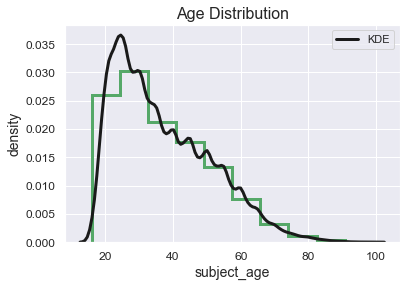

In [20]:
ax = sns.distplot(df_age.subject_age, bins=10, hist=True, kde=True, 
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                             "alpha": 1, "color": "g"}
                 )
ax.set_title('Age Distribution', fontsize=16)
ax.set_xlabel('subject_age', fontsize=14)
ax.set_ylabel('density', fontsize=14)
ax.tick_params(labelsize=12)

In [21]:
# Convert the age distribtution into categories
age_dist = {1:'Age 10 to 19', 2:'Age 20 to 29', 3:'Age 30 to 39', 4:'Age 40 to 49', 5:'Age 50 to 59',
            6:'Age 60 to 69', 7:'Age 70 to 79', 8:'Age 80 to 89', 9:'Age 90 to 99'}
df_age['age_dist'] = df_age.apply(lambda row: age_dist[int(row.subject_age/10)], axis=1)

In [22]:
for i in sd_stop['stop_cause'].value_counts().index[0:8]:
    def stop_cause_dist(row):
        if row.stop_cause==i:
            return 1
        else:
            return 0
    df_age[i] = df_age.apply(stop_cause_dist, axis=1)

In [23]:
df_age.head()

,Unnamed: 15,Unnamed: as16,arrested,contraband_found,obtained_consent,property_seized,sd_resident,searched,service_area,stop_cause,...,Race_Description,age_dist,Moving Violation,Equipment Violation,Radio Call/Citizen Contact,"Muni, County, H&S Code",Personal Knowledge/Informant,"Suspect Info (I.S., Bulletin, Log)",No Cause Specified on a Card,Personal Observ/Knowledge
0,NaN,NaN,N,N,N,N,Y,N,110,Moving Violation,...,WHITE,Age 20 to 29,1,0,0,0,0,0,0,0
1,NaN,NaN,N,NaN,NaN,NaN,Y,N,320,Moving Violation,...,WHITE,Age 40 to 49,1,0,0,0,0,0,0,0
2,NaN,NaN,N,NaN,NaN,NaN,Y,N,320,Moving Violation,...,LAOTIAN,Age 20 to 29,1,0,0,0,0,0,0,0
3,NaN,NaN,N,NaN,NaN,NaN,Y,N,610,Moving Violation,...,WHITE,Age 20 to 29,1,0,0,0,0,0,0,0
4,NaN,NaN,N,NaN,NaN,NaN,N,N,930,Equipment Violation,...,HISPANIC,Age 30 to 39,0,1,0,0,0,0,0,0


In [24]:
df_age_major_8 = df_age[df_age['stop_cause'].isin(df_age['stop_cause'].value_counts().index[0:8])]

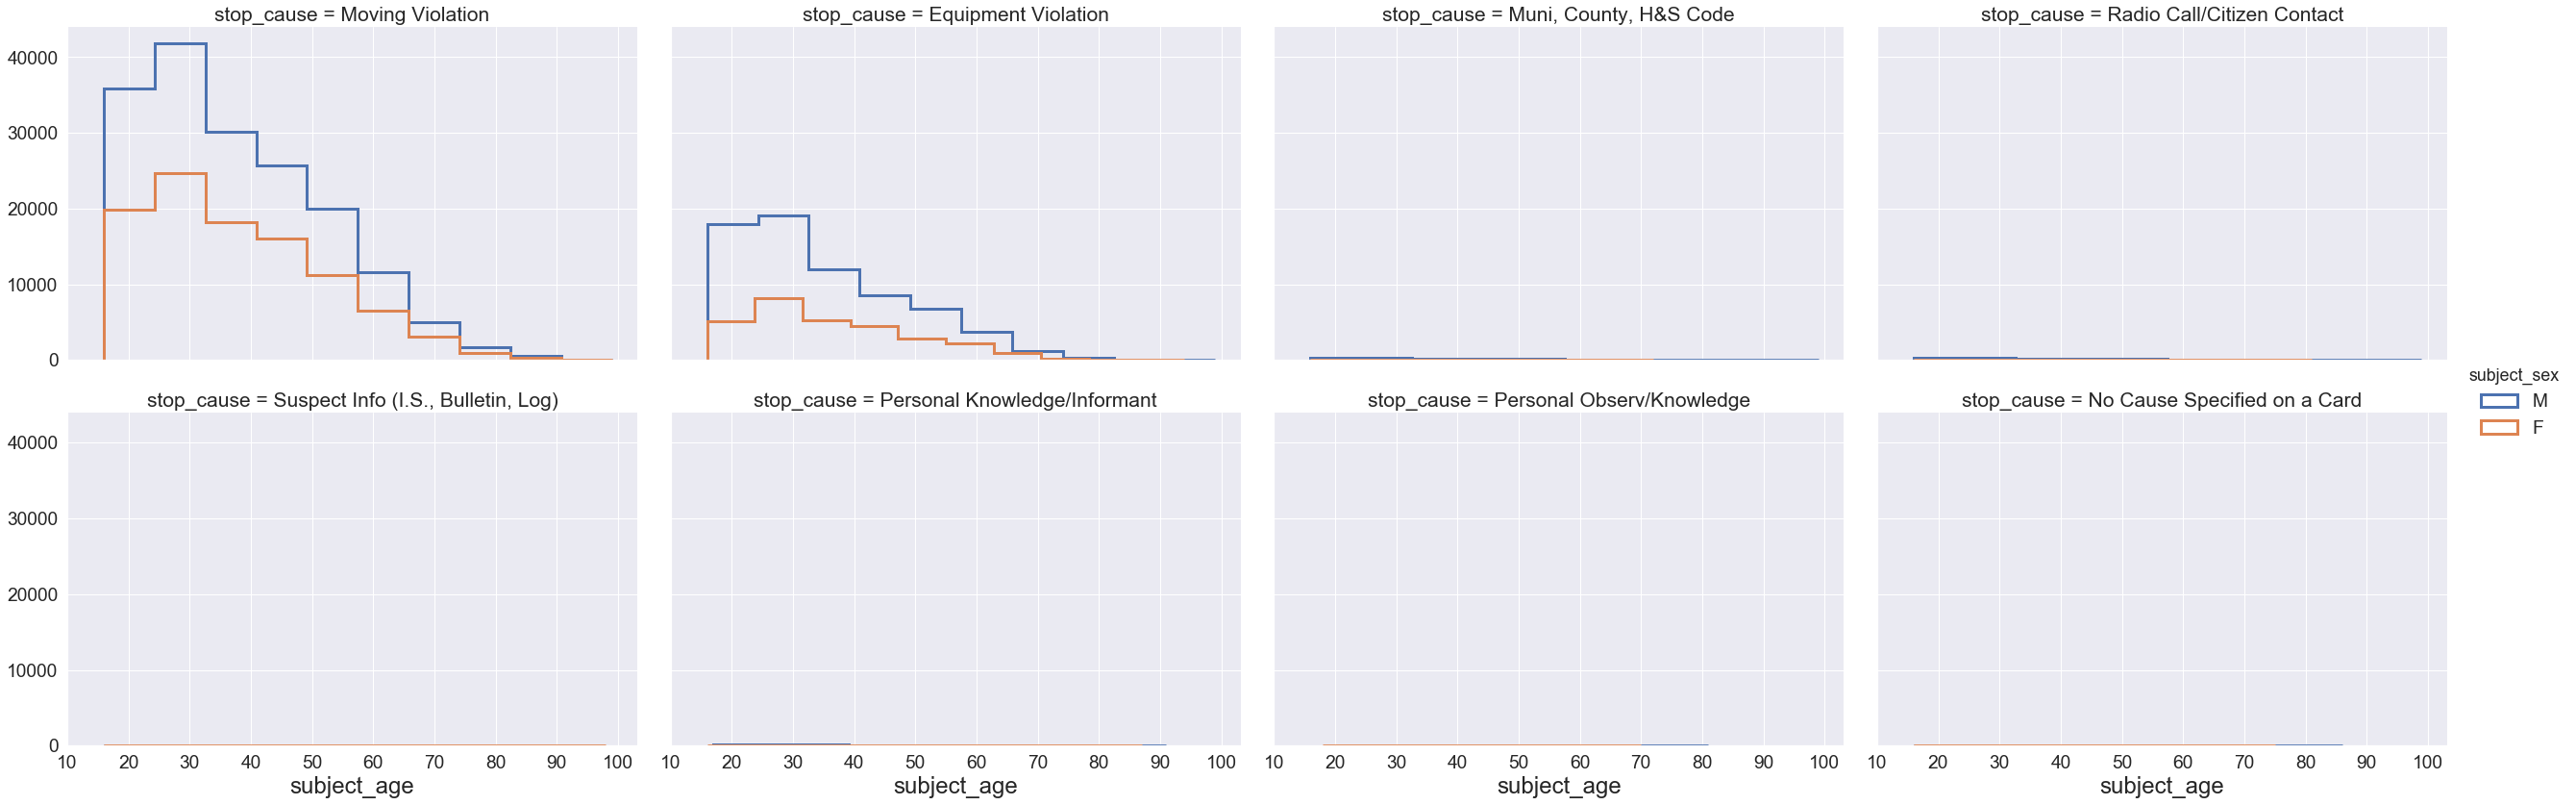

In [25]:
sns.set(font_scale=1.75)
g = sns.FacetGrid(df_age_major_8, 
                  col='stop_cause',
                  hue='subject_sex',
                  col_wrap=4,
                  height=6,
                  aspect=1.5,
                 )
g = g.map(sns.distplot, 'subject_age', 
          bins=10,
          hist=True, kde=False, 
          kde_kws={"color": "k", "lw": 3, "label": "KDE"},
          hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1},
         )
g.set(xticks=np.arange(10,110,10))
g.set_xlabels(fontsize=24)
g.set_ylabels(fontsize=24)
g.add_legend()

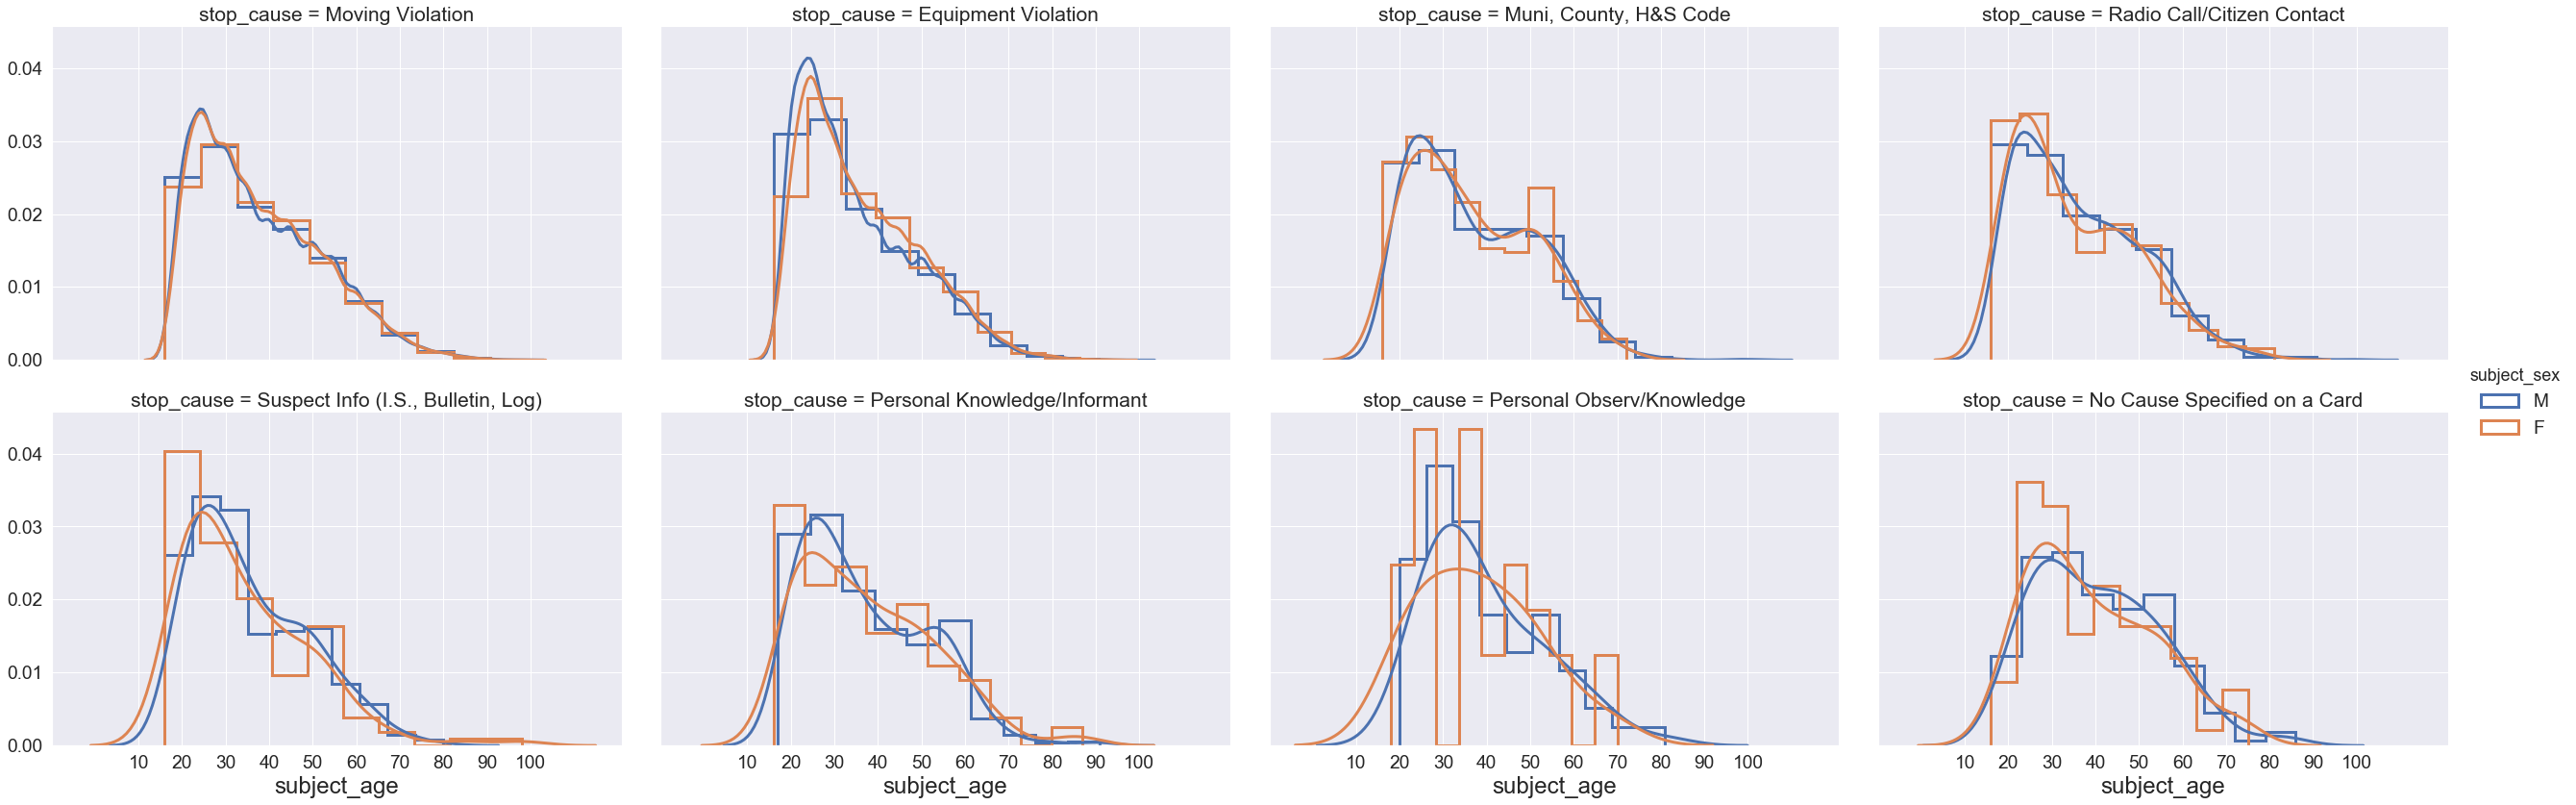

In [26]:
sns.set(font_scale=1.75)
g = sns.FacetGrid(df_age_major_8, 
                  col='stop_cause',
                  hue='subject_sex',
                  col_wrap=4,
                  height=6,
                  aspect=1.5,
                 )
g = g.map(sns.distplot, 'subject_age', 
          bins=10,
          hist=True, kde=True, 
          kde_kws={"lw": 3, "label": "KDE"},
          hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1},
         )
g.set(xticks=np.arange(10,110,10))
g.set_xlabels(fontsize=24)
g.set_ylabels(fontsize=24)
g.add_legend()

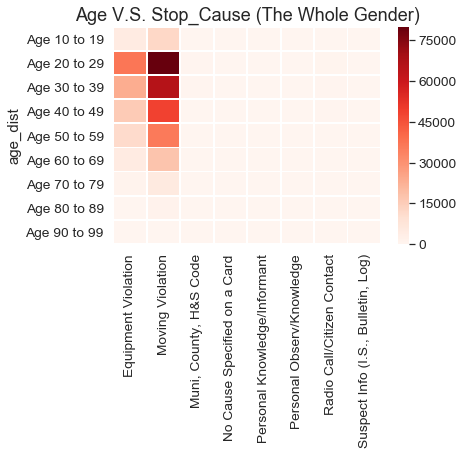

In [27]:
data = df_age_major_8
sns.set(font_scale=1.25)
ht = pd.pivot_table(data, 
                    index='age_dist', 
                    values=data['stop_cause'].value_counts().index, 
                    aggfunc=np.sum)
g0 = sns.heatmap(ht,vmin=0, vmax=80000, cmap='Reds', annot=False, linewidths=0.8)
g0 = g0.set_title('Age V.S. Stop_Cause (The Whole Gender)', fontsize=18)

*Use FacetGrid in Seaborn to have the differentiation on Male and Female heatmaps*

**The heatmaps focus on Age and the Stop Cause**

In [29]:
df_age_counts = df_age_major_8[['stop_cause', 'subject_sex', 'subject_race', 
                                'subject_age', 'age_dist', 'Race_Description']]

age_pivot = pd.pivot_table(df_age_major_8, 
                           index='age_dist',
                           columns='subject_sex',
                           values=df_age_major_8['stop_cause'].value_counts().index, 
                           aggfunc=np.sum)

def stop_cause_age_counts(row):
    try:
        return age_pivot.loc[row.age_dist, row.stop_cause][row.subject_sex]
    except TypeError:
        return None

df_age_counts['age_stop_cause_count'] = df_age_counts.apply(stop_cause_age_counts, axis=1)

/Users/macyeh/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [31]:
print(df_age_counts.head())

            stop_cause subject_sex subject_race  subject_age      age_dist  \
0     Moving Violation           M            W           24  Age 20 to 29   
1     Moving Violation           M            W           42  Age 40 to 49   
2     Moving Violation           M            L           29  Age 20 to 29   
3     Moving Violation           M            W           23  Age 20 to 29   
4  Equipment Violation           M            H           35  Age 30 to 39   

  Race_Description  age_stop_cause_count  
0            WHITE                 54399  
1            WHITE                 30067  
2          LAOTIAN                 54399  
3            WHITE                 54399  
4         HISPANIC                 16515  


Text(0.5, 0.98, 'Age V.S. Stop_Cause')

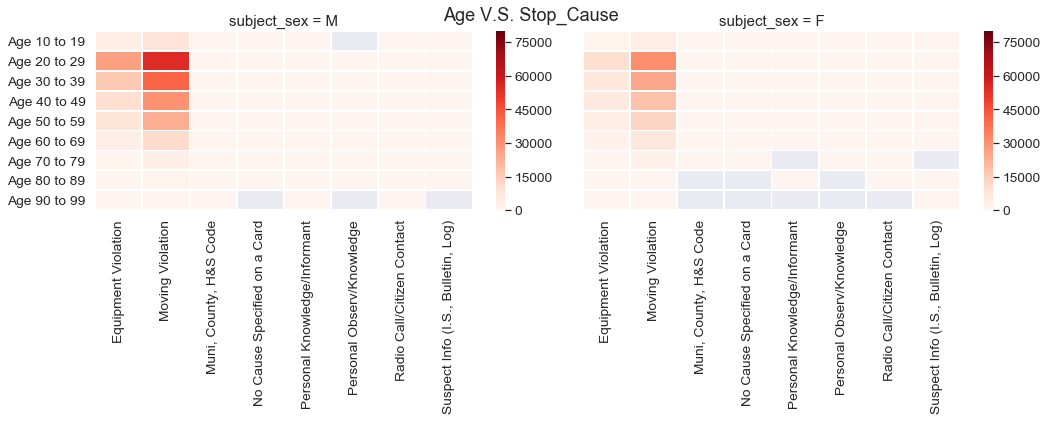

In [40]:
def facet_heatmap(*args, **kwargs): ## Define Plot Function
    data = kwargs.pop('data')
    ht = pd.pivot_table(data=data,
                        index='age_dist',
                        columns='stop_cause',
                        values='age_stop_cause_count'
                        )
    sns.heatmap(ht, cmap='Reds', annot=False, linewidths=0.8, vmin=0, vmax=80000)

g = sns.FacetGrid(data=df_age_counts, col='subject_sex', height=6, aspect=1.25)
g.map_dataframe(func=facet_heatmap)
g.fig.suptitle('Age V.S. Stop_Cause') 

### Observation and Conclusion

With the distributions and the heatmaps, two pull-over reaons from San Diego PD are 

1. **Moving Violation**
2. **Equipment Violation**

These reason counts make sense with the understanding and encountering of our daily life.

We also observe the pull-over rate with the age distribution and sex distribution.

The people with the **age 20 to 29** are inclined to be pulled over with the spotting moving violation. With the age increases, the pull-over rate is reduced. It also might explain the insurance company will have the high premium at this range of the age. The ***male*** drivers are also intended to be pulled compared to ***female*** drivers. 

## Race/Sex-Stop Cause Relation Analysis
The procedure includes:
1. Data Clean
2. Data Visualization
3. Observation and Conclusion